### Idea
Transform gps tracks:
- connect individual points with lines
- resample simmetric points (each 10 sec?)
- ??? resnap the generated points (learn how to do that - Iztok/Alen)
- isolate route Ljubljana - Venice (special data folder)
- normalize the new data
    - normalize method 1: min -> 0, max -> 1
    - normalize method 2: normalize GPS coordinates (-90, 90), (0, 360)

data directory: C:\Users\Uporabnik\Code\strojno_ucenje\.datasets\gps_tracks\matchedData.txt

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = "../.datasets/gps_tracks/"
BASIC_FILE = "matchedData.txt"

### read the data from our basic text file
text_data_file = pd.read_table(DATA_DIR + BASIC_FILE, delimiter=';', usecols=(5,6), header=0)
### check how the data looks
print(text_data_file.shape, '\n' ,text_data_file)

(3364, 2) 
                                             description  \
0                                    Ljubljana - Venice   
1     Ljubljana - [Zrkovska cesta 182a, 2000 Maribor...   
2     Ljubljana - Genoa, Savona - [Raičeva ulica 121...   
3     [Vipava - območje jedra s spomeniki in znameni...   
4                 Ljubljana - Savona, Genoa - Ljubljana   
5              Ljubljana - Maribor, Maribor - Ljubljana   
6     Ljubljana - Trieste, Trieste - [Černigojeva ul...   
7     [Tivolska cesta 48, 1000 Ljubljana, Slovenia] ...   
8                                     Milan - Ljubljana   
9                                   Maribor - Ljubljana   
10    [Srednje Gameljne 23, 1211 Ljubljana - Šmartno...   
11               Ljubljana - Venice, Venice - Ljubljana   
12               Ljubljana - Venice, Venice - Ljubljana   
13    [Savinova ulica 11, 1000 Ljubljana, Slovenija]...   
14    [Ramovševa ulica 65, 1000 Ljubljana, Slovenija...   
15              Ljubljana - Trieste, Venice 

In [31]:
"""
Gather only the tracks that have "venice" in the description (index 0)
"""
text_data_lj_ve = pd.DataFrame(columns= ['description', 'snapped'])
for index, route in text_data_file.iterrows():
    if route['description'].find('Venice') > 0:
        #print(route[['description']])
        text_data_lj_ve.loc[len(text_data_lj_ve)] = route
print(counter, text_data_lj_ve.shape, '\n')

939 (939, 2) 



In [33]:
routes = text_data_file['snapped']
routes_lj_ve = text_data_lj_ve['snapped']
print(routes.shape, routes_lj_ve.shape)

(3364,) (939,)


In [34]:
### prepair an extraction methood, that transforms the string above to a list of numpy arrays
def string_to_list(data):
    new_data = []
    for track in data:
        track = track[2 : len(track) - 2].split('], [')
        new_track = []
        for t in track:
            t = t.split(', ')
            new_track.append(t)
        new_track = np.array(new_track)
        new_data.append(new_track.astype(float))
    return new_data

In [37]:
TRACK_FILE = "snapped_tracks"
TRACK_FILE_LJ_VE = "snapped_tracks_lj_ve"
DATA_DIR = "../.datasets/gps_tracks/resampled/"
### save the transformed data to our first support file

tracks = np.array(string_to_list(routes))
tracks_lj_ve = np.array(string_to_list(routes_lj_ve))

np.save(DATA_DIR + TRACK_FILE, tracks)
np.save(DATA_DIR + TRACK_FILE_LJ_VE, tracks_lj_ve)


In [39]:
def getMinMaxValues(data):
    ### methood that returns the min and max values of each column
    minMax = np.zeros((2,2))
    minMax[0,0] = np.finfo('d').max
    minMax[0,1] = np.finfo('d').max
    for array in data:
        #print(array[:,0].shape)
        tempMinMax = np.zeros((2,2))
        tempMinMax[0,0] = np.finfo('d').max
        tempMinMax[0,1] = np.finfo('d').max
        
        tempMinMax[0,0] = np.amin(array[:,0])
        tempMinMax[1,0] = np.amax(array[:,0])
        tempMinMax[0,1] = np.amin(array[:,1])
        tempMinMax[1,1] = np.amax(array[:,1])
        
        #print(tempMinMax[0,0],tempMinMax[1,0],tempMinMax[0,1],tempMinMax[1,1])
        
        for j in range(2):
            # test for min
            if minMax[0,j] > tempMinMax[0,j]:
                minMax[0,j] = tempMinMax[0,j]
            # test for max
            if minMax[1,j] < tempMinMax[1,j]:
                minMax[1,j] = tempMinMax[1,j]
    
    return minMax

In [40]:
def normalize(data, minMax):
    """
    Function that normalizes the generated quadratic function data.
    Parameters:
        - data, (list of np.array of shape (n_of_points, 2))
        - minMax, (np.array) where [0,i] represents the min value and [1,i] represents the max value of column i
    """
    for array in data:
        for i in range(2):
            #print(array.shape)
            array[:,i] = (array[:,i] - minMax[0,i]) 
            array[:,i] = array[:,i] / (minMax[1,i] - minMax[0,i])
    
    return data

[[ 41.38698578   7.65055418]
 [ 51.19366837  21.91259575]]
(500, 2)


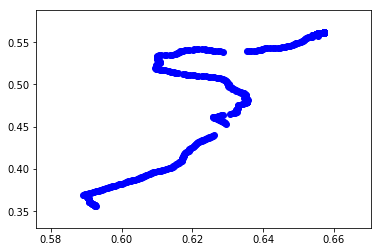

(500, 2)


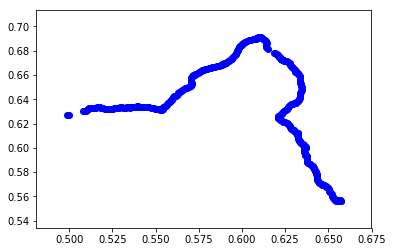

(500, 2)


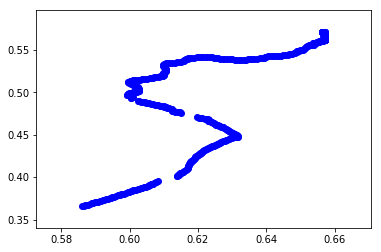

(500, 2)


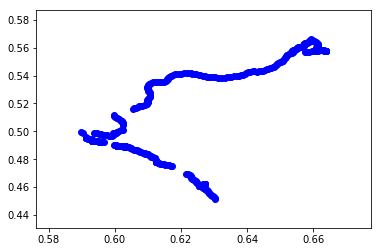

(500, 2)


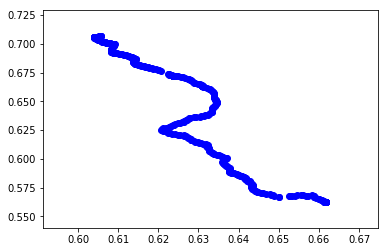

In [51]:
### test the data
print(minMax)
for _ in range(5):
    i = np.random.randint(tracks_lj_ve.shape[0])
    print(tracks_lj_ve[0].shape)
    
    plt.scatter(tracks_lj_ve[i][:,0], tracks_lj_ve[i][:,1], color='blue')
    #plt.scatter(tracks[i,:,0], tracks_out[i,:,1], color='red')
    plt.show()

In [41]:
NORMALIZED_FILE = "normalized_tracks"
NORMALIZED_FILE_LJ_VE = "normalized_tracks_lj_ve"

### loads tracks if needed
#tracks = np.load(DATA_DIR + TRACK_FILE)

### get the min and max values of all the tracks
minMax = getMinMaxValues(tracks)
minMax_lj_ve = getMinMaxValues(tracks_lj_ve)

### normalize the data
normalized_tracks = normalize(tracks, minMax)
normalized_tracks_lj_ve = normalize(tracks_lj_ve, minMax_lj_ve)

### test normalization
print(getMinMaxValues(normalized_tracks))
print(getMinMaxValues(normalized_tracks_lj_ve))

### save normalized data
np.save(DATA_DIR + NORMALIZED_FILE, normalized_tracks)
np.save(DATA_DIR + NORMALIZED_FILE_LJ_VE, normalized_tracks_lj_ve)

[[ 0.  0.]
 [ 1.  1.]]
[[ 0.  0.]
 [ 1.  1.]]
